# Functions for data

In [1]:
!pip install pandas-datareader
import pandas_datareader as web

In [2]:
# import pandas_datareader.data as web
import datetime
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# we plan to evaluate the 1 week data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,3,1)

In [3]:
# a function to read a single stock
def get_stock(ticker,start,end):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Adj Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

import functools as ft
# from functools import reduce

# a function to read different stocks and combine them into a single table
def combine_stocks(tickers,start,end):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i,start,end))
        
    df_merged = ft.reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    print(df_merged.head())
    return df_merged

In [4]:
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
historical_price=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [5]:
# we plan to evaluate the 2 week data as forecasting period
# this is the actual data as well as S0
start = datetime.datetime(2021,3,1)
end = datetime.datetime(2021,5,1)
test_data=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-03-01  1564.707642
2021-03-02  1492.608765
2021-03-03  1575.853149
2021-03-04  1541.914307
2021-03-05  1533.275024
              SOL-USD
Date                 
2021-03-01  14.955588
2021-03-02  13.958921
2021-03-03  14.115591
2021-03-04  13.097983
2021-03-05  12.610443
                ETH-USD    SOL-USD
Date                              
2021-03-01  1564.707642  14.955588
2021-03-02  1492.608765  13.958921
2021-03-03  1575.853149  14.115591
2021-03-04  1541.914307  13.097983
2021-03-05  1533.275024  12.610443


In [6]:
#combination of both historical and test data
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,5,1)
data_portfolio=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


# Functions used in GBM

In [7]:
# for GBM
# a function to get S0, dt, T, N, t
def inputs_get(data,time_period,day,col_num):
    '''
    data: all the data, including both historical and future actual data
    time_period: number of days for forecasting
    day: the starting day num for forecasting
    col_num: index of column for the stock we want to forecast
    '''
    #stocks is the stock ticker
    # start date is the start of forecasting period
    S0=data.iloc[day,col_num]
    dt=1
    #n_of_wkdays = pd.date_range(start = start_date, end = pd.to_datetime(end_date, format = "%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1,6) else 0).sum()
    #n_of_wkdays = pd.date_range(start = start_date, end = pd.to_datetime(end_date, format = "%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1,6) else 0).sum()
    n_of_wkdays=len(data.iloc[day:,0])
    T = n_of_wkdays
    N=T/dt
    t=np.arange(1, int(N) + 1)
    return S0,dt,T,N,t

In [8]:
# for GBM
# a function calculating historical mean return and volatility
def mean_and_sigma(data,col_num):
    '''
    data: historical data before starting day of forecasting
    col_num: index of column for the stock we want to forecast
    '''
    returnt=pd.DataFrame(columns=data.columns)
    for i in returnt:
        returnt[i]=np.log(data[i]).pct_change()
    mu=np.mean(returnt.iloc[:,col_num])
    sigma=np.std(returnt.iloc[:,col_num])
    return mu, sigma

In [9]:
# a function to obtain covariance between stocks
def cov_stocks(data):
    '''
    data: historical data before starting day of forecasting
    '''
    returnt=pd.DataFrame(columns=data.columns)
    for i in returnt.columns:
        returnt[i]=np.log(data[i]).pct_change()

    Cov = np.cov(returnt.iloc[1:,0],returnt.iloc[1:,1] )   
    return Cov



In [10]:
# function to estimate prices of an correlated stock as a foundation of price sperad forecasting
def GBMsimulatormulti(So, t, mu, sigma, cov, T, N, dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    dim: number of stocks within the portfolio
    """
    A = np.linalg.cholesky(cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

# function of monte carlo simulation and later average calculating
def monte_carlo_multi(S0,t,mu,sigma,cov,T,N,portfolio_pre,dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    portfolio_pre: dataframe of future actual data
    dim: number of stocks within the portfolio
    """
    prices_matrix=[]
    means=[]
    volatilities=[]
    for i in range(500):
        prices=GBMsimulatormulti(S0,t,mu,sigma,cov,T,N,dim)[0]
        prices_matrix.append(prices)
        means.append(np.mean(prices))
        volatilities.append(np.std(prices))
    prices_matrixframe=pd.DataFrame(np.concatenate(prices_matrix))
    forecasted_price=[]
    for i in range(len(t)):
        forecasted_price.append(np.mean(prices_matrixframe[i]))
    portfolio_pre['forecasted_price3']=forecasted_price
    return portfolio_pre
    
# function of final result estimating
def forecast_multi(S0,t,mu,sigma,cov,T,N,dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    dim: number of stocks within the portfolio
    """
    prices=GBMsimulatormulti(S0,t,mu,sigma,cov,T,N,dim)[0]
    prices_matrixframe=pd.DataFrame()
    for i in range(2):
        prices_matrixframe[i]=prices[i]
    new_price=[]
    for i in range(len(t)):
        mu=np.mean(prices_matrixframe.iloc[i,:])
        new_price.append(mu)
    return new_price

# Setting trading signals and trading time

In [11]:
# a function to determine signals!!!
'''
Notice:only care about future without considering previous performance 
will future price revert to mean？ --- yes，then must trade now，and sell it
will future price keep increasing？ --- yes，then hold until maximum is reached to trade
'''
def signals(new_portfolio,i,threshold):
    if new_portfolio['moving_zs'][i]>threshold:
        if new_portfolio['moving_zs'][i+1]<threshold:
            #will tmr convert to mean? --yes
            return -1
        elif new_portfolio['moving_zs'][i+1]>threshold:
            # tmr won't convert to mean? then is today the highest point to trade before the price spread convert to mean next time?
            if np.array(np.where(np.array(new_portfolio['moving_zs'][i:])<threshold)).size!=0:
                if np.argmax(new_portfolio['moving_zs'][i:np.min(np.where(np.array(new_portfolio['moving_zs'][i:])<threshold))+i+1])==0:
                    return -1
            else:
                if np.argmax(new_portfolio['moving_zs'][i:-1])==0:
                    return -1
            
                        
    elif new_portfolio['moving_zs'][i]<-threshold:
        if new_portfolio['moving_zs'][i+1]>-threshold:
            return 1
        elif new_portfolio['moving_zs'][i+1]<-threshold:
            if np.array(np.where(np.array(new_portfolio['moving_zs'][i:])>-threshold)).size!=0:
                if np.argmin(new_portfolio['moving_zs'][i:np.min(np.where(np.array(new_portfolio['moving_zs'][i:])>-threshold))+i+1])==0:
                    return 1
            else:
                if np.argmin(new_portfolio['moving_zs'][i:-1])==0:
                    return 1
           
    return 0

In [12]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
# a function to determine signals without considering price spread forercasted by gbm on a daily basis (traditional pair trading strategy execution)!!!

def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [13]:
data_portfolio=pair_signals_gbm(data_portfolio,61,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Functions to determine postisions and plot the trading point

In [20]:
import matplotlib.pyplot as plt
# function to create trading signal & position table and plot the trading strategy
def pair_trading(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                positions1[i+1]=0-positions1[i]
            elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        
    for i in range(len(data['signals2'])-1): #holding days is 3 in this case
        if positions2[i]!=0 and positions2[i+1:].index(0)==0:
            if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                # tell whether the last buying is yesterday or not and whether we need to sum them
                positions2[i+1]=0-positions2[i]
            elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                positions2[i+1]=0-sum(positions2[np.max(np.where(np.array(positions2[:i+1])==0))+1:i+1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data





,ETH-USD,SOL-USD,signals1,signals2,movingzs,positions1,positions2
Date,,,,,,,
2021-01-01,730.367554,1.842084,0,0,0.000000,0,0
2021-01-02,774.534973,1.799275,0,0,0.000000,0,0
2021-01-03,975.507690,2.161752,0,0,0.000000,0,0
2021-01-04,1040.233032,2.485097,0,0,0.000000,0,0
2021-01-05,1100.006104,2.157217,0,0,0.000000,0,0
2021-01-06,1207.112183,1.929217,0,0,0.000000,0,0
2021-01-07,1225.678101,2.372745,0,0,0.000000,0,0
2021-01-08,1224.197144,3.219887,0,0,0.000000,0,0
2021-01-09,1281.077271,3.385382,0,0,0.000000,0,0


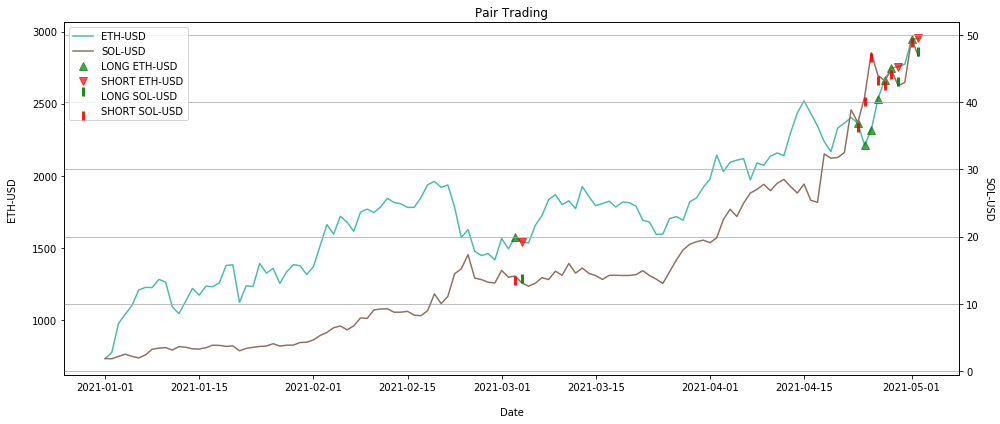

In [24]:
pair_trading(data_portfolio,'ETH-USD','SOL-USD',1.5)

# Functions to calculate the return and evaluation

In [25]:
# functions to calculate profit and losses!!!
def pnl(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = (portfolio.index[-1] - portfolio.index[0]).days
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    return portfolio







Number of days =  120
CAGR = 581.002%


,ETH-USD,holdings1,cash1,total asset1,return1,positions1,SOL-USD,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
Date,,,,,,,,,,,,,,,,
2021-01-02,774.534973,0.000000,100000.000000,100000.0,0.0,0,1.799275,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-03,975.507690,0.000000,100000.000000,100000.0,0.0,0,2.161752,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-04,1040.233032,0.000000,100000.000000,100000.0,0.0,0,2.485097,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-05,1100.006104,0.000000,100000.000000,100000.0,0.0,0,2.157217,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-06,1207.112183,0.000000,100000.000000,100000.0,0.0,0,1.929217,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-07,1225.678101,0.000000,100000.000000,100000.0,0.0,0,2.372745,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-08,1224.197144,0.000000,100000.000000,100000.0,0.0,0,3.219887,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-09,1281.077271,0.000000,100000.000000,100000.0,0.0,0,3.385382,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-10,1262.246704,0.000000,100000.000000,100000.0,0.0,0,3.466111,0.000000,100000.000000,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5


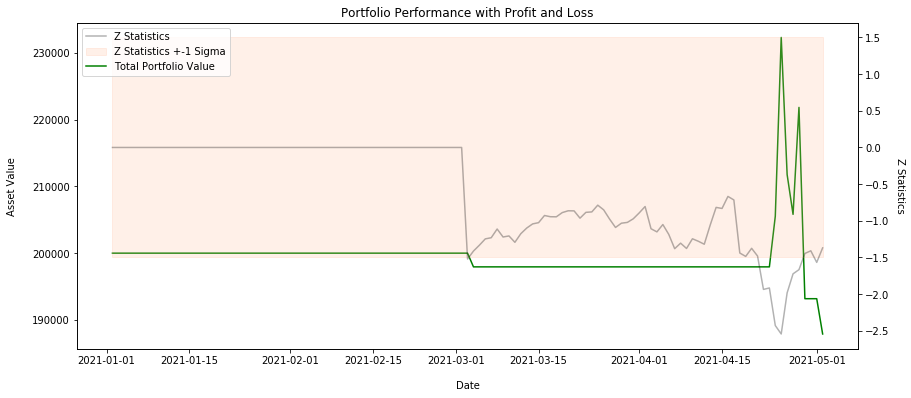

In [26]:
pnl(data_portfolio,'ETH-USD','SOL-USD')

# Use of spread to determine the signals

In [27]:
# a useful function for calculating spread
from sklearn import linear_model    
def regr(x,y):
    regr = linear_model.LinearRegression()
    x_constant = np.column_stack([np.ones(len(x)), x])
    regr.fit(x_constant, y)
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

In [28]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
# a function to determine signals considering price spread forercasted by gbm on a daily basis (adjusted pair trading strategy execution)!!!
def pair_signals_gbm_spread(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1):
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=regr(new_portfolio.iloc[:,0],new_portfolio.iloc[:,1])
        
        averages=[0]*(time_period)
        sds=[0]*(time_period)
        z_scores=[0]*(time_period)
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
        
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs

    return data

        

In [31]:
data_portfolio=pair_signals_gbm_spread(data_portfolio,61,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*in

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: inva

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,ETH-USD,SOL-USD,signals1,signals2,movingzs,positions1,positions2
Date,,,,,,,
2021-01-01,730.367554,1.842084,0,0,0.000000,0,0
2021-01-02,774.534973,1.799275,0,0,0.000000,0,0
2021-01-03,975.507690,2.161752,0,0,0.000000,0,0
2021-01-04,1040.233032,2.485097,0,0,0.000000,0,0
2021-01-05,1100.006104,2.157217,0,0,0.000000,0,0
2021-01-06,1207.112183,1.929217,0,0,0.000000,0,0
2021-01-07,1225.678101,2.372745,0,0,0.000000,0,0
2021-01-08,1224.197144,3.219887,0,0,0.000000,0,0
2021-01-09,1281.077271,3.385382,0,0,0.000000,0,0


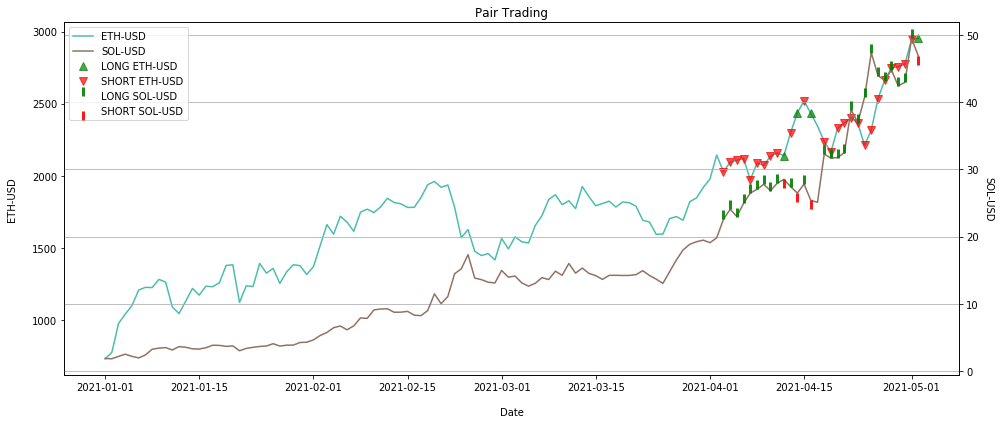

In [32]:
pair_trading(data_portfolio,'ETH-USD','SOL-USD',1.5)

Number of days =  120
CAGR = nan%


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


,ETH-USD,holdings1,cash1,total asset1,return1,positions1,SOL-USD,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
Date,,,,,,,,,,,,,,,,
2021-01-02,774.534973,0.000000e+00,1.000000e+05,100000.0,0.0,0,1.799275,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-03,975.507690,0.000000e+00,1.000000e+05,100000.0,0.0,0,2.161752,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-04,1040.233032,0.000000e+00,1.000000e+05,100000.0,0.0,0,2.485097,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-05,1100.006104,0.000000e+00,1.000000e+05,100000.0,0.0,0,2.157217,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-06,1207.112183,0.000000e+00,1.000000e+05,100000.0,0.0,0,1.929217,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-07,1225.678101,0.000000e+00,1.000000e+05,100000.0,0.0,0,2.372745,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-08,1224.197144,0.000000e+00,1.000000e+05,100000.0,0.0,0,3.219887,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-09,1281.077271,0.000000e+00,1.000000e+05,100000.0,0.0,0,3.385382,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5
2021-01-10,1262.246704,0.000000e+00,1.000000e+05,100000.0,0.0,0,3.466111,0.000000e+00,1.000000e+05,100000.000000,0.000000,0,0.000000,200000.000000,1.5,-1.5


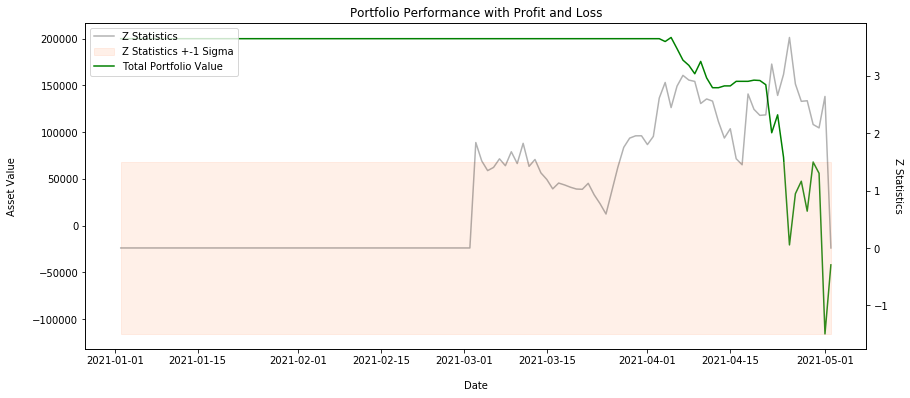

In [33]:
pnl(data_portfolio,'ETH-USD','SOL-USD')